
# Universidad de Buenos Aires
# Deep Learning - Examen - Parte 2
# Agosto 2024


El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta el **Lunes 26 de agosto, 23:59hs**. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” a cargar en el siguiente formulario de google: [link](https://docs.google.com/forms/d/e/1FAIpQLSdqvLFa--M6RXuXdg2E9gpvvwyrEbMiqhD6B7cn1ACqwTMc6g/viewform?usp=sf_link)



Recordar compartir a las siguientes direcciones: maxit1992@gmail.com y lelectronfou@gmail.com así podemos acceder y corregir. Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab.

**Consideraciones a tener en cuenta:**
- Se entregará 1 solo colab para la totalidad del examen.
- Renombrar el archivo de la siguiente manera: **APELLIDO-NOMBRE-DL-Examen ABRIL 2024.ipynb**
- Los códigos deben poder ejecutarse.
- Los resultados, cómo el código y las explicaciones deben quedar guardados y visualizables en el correspondiente link.
- Prestar atención a las consignas, responder las preguntas cuando corresponda.

---

# Parte 2.a

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset CIFAR10, las clases `['cat', 'dog', 'frog']`. Entrene solamente usando las clases mencionadas (ver dataset de ejemplo).

Sobre dicho modelo, evalue el comportamiento de la accuracy bajo los siguientes tamaños de `kernel_size = [5, 7, 9, 11]`.

Grafique la evolución de la función de perdida y la accuracy (para train y test) para cada modelo y elija el que considera mejor. En caso de encontrar overfitting, tome las medidas adecuadas.





In [86]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm # para graficar la barra de avance

Files already downloaded and verified
Files already downloaded and verified


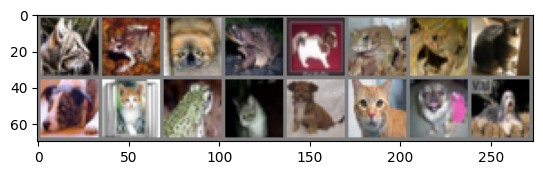

cat frog dog frog dog frog frog cat dog cat frog cat dog cat dog dog


In [87]:
class FilteredDataset(Dataset):
    def __init__(self, original_dataset, selected_labels):
        self.original_dataset = original_dataset
        self.selected_labels = selected_labels

        # Crear un diccionario para remapear las etiquetas seleccionadas a índices ascendentes
        self.label_map = {label: idx for idx, label in enumerate(selected_labels)}

        # Filtrar los índices de las imágenes que pertenecen a las clases seleccionadas
        self.indices = [i for i, label in enumerate(original_dataset.targets) if label in selected_labels]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        # Obtener el índice del dataset original
        original_idx = self.indices[idx]

        # Obtener la imagen y la etiqueta correspondientes
        image, label = self.original_dataset[original_idx]

        # Remapear la etiqueta
        remapped_label = self.label_map[label]

        return image, remapped_label


# Definir transformaciones para las imágenes
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Descargar y cargar el conjunto de datos CIFAR-10
original_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                download=True, transform=transform)

original_test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Elegir 3 clases específicas (por ejemplo: 'cat', 'dog', 'frog')
classes = original_train_dataset.classes
selected_classes = ['cat', 'dog', 'frog']
selected_class_indices = [classes.index(cls) for cls in selected_classes]

# Crear un nuevo conjunto de datos filtrado
filtered_train_dataset = FilteredDataset(original_train_dataset, selected_class_indices)
filtered_test_dataset = FilteredDataset(original_test_dataset, selected_class_indices)

# define tamaño de batch
batch_size = 16

# Crear un DataLoader para el nuevo conjunto de datos
trainloader = DataLoader(filtered_train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(filtered_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Función para mostrar imágenes
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Obtener un lote de entrenamiento
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Mostrar imágenes
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{selected_classes[labels[j]]}' for j in range(batch_size)))


# Implementación 2.a

## Análisis de los datos disponibilizados

In [88]:
# tamaños de datasets y dataloaders
print(f'Batch size: {batch_size} \nMuestras para train: {len(filtered_train_dataset)}\nMuestras para test: {len(filtered_test_dataset)}\nBatches para train: {len(trainloader)}\nBatches para test: {len(testloader)}')


Batch size: 16 
Muestras para train: 15000
Muestras para test: 3000
Batches para train: 938
Batches para test: 188


In [89]:
# Función para mostrar una sola imagen
def imshow_single(img, gray=False):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    if gray:
      plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap="gray")
    else:
      plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    print(f'Clase: {selected_classes[labels[0]]}')
    print('-------------')
    print(f'Dimensiones: {img.shape}')

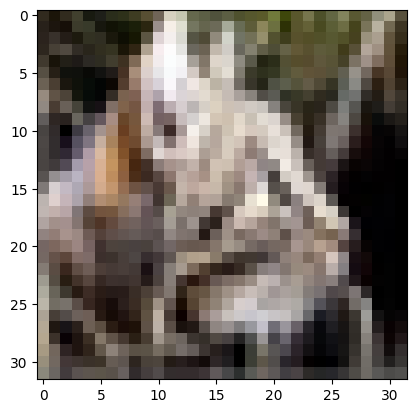

Clase: cat
-------------
Dimensiones: torch.Size([3, 32, 32])


In [90]:
imshow_single(images[0])

### Verifico si todas las imágenes tienen la misma dimensión

In [91]:
def check_image_dimensions(dataloader):
    dimensions = None
    for images, _ in dataloader:
        for img in images:
            if dimensions is None:
                dimensions = img.shape
            elif img.shape != dimensions:
                print(f'Error: Dimensión inconsistente encontrada: {img.shape} diferente de {dimensions}')
                return False
    return True

# Verifica dimensiones de las imágenes en el DataLoader de train
if check_image_dimensions(trainloader):
    print("Todas las imágenes en el conjunto de entrenamiento tienen las mismas dimensiones.")
else:
    print("No todas las imágenes en el conjunto de entrenamiento tienen las mismas dimensiones.")

# Verifica dimensiones de las imágenes en el DataLoader de test
if check_image_dimensions(testloader):
    print("Todas las imágenes en el conjunto de prueba tienen las mismas dimensiones.")
else:
    print("No todas las imágenes en el conjunto de prueba tienen las mismas dimensiones.")

Todas las imágenes en el conjunto de entrenamiento tienen las mismas dimensiones.
Todas las imágenes en el conjunto de prueba tienen las mismas dimensiones.


- La dimensiones de las imágenes es de 32x32x3, por ende vamos a usar una primera capa de convolución con tres canales de entrada.

---

In [92]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Arquitectura base - Capa de convolución

Implemente una arquitectura de red neuronal basada en CNN para identificar del dataset CIFAR10, las clases `['cat', 'dog', 'frog']`. Entrene solamente usando las clases mencionadas (ver dataset de ejemplo).

Sobre dicho modelo, evalue el comportamiento de la accuracy bajo los siguientes tamaños de `kernel_size = [5, 7, 9, 11]`.

Grafique la evolución de la función de perdida y la accuracy (para train y test) para cada modelo y elija el que considera mejor. En caso de encontrar overfitting, tome las medidas adecuadas.


In [93]:
# bloque de convolución para emplear en mi red
def conv_block(c_in, c_out, k, p='same', s=1, pk=3, ps=2, pp=1):
  '''
  This function use a sequential pytorch object that does the forward operation over it's steps.
  Inputs:
    c_in: canales (kernels) de entrada
    c_out: canales (kernels) de salida
    k: tamaño del kernel kxk
    p: tamaño del padding de la convolución
    s: stride de la convolución
    pk: tamaño del kernel del pooling
    ps: stride de la pooling
    pp: padding en la pooling
  Output: torch.nn.Sequential with the following architecture:
    - A convolutional layer
    - An activation layer
    - A pooling layer
  '''
  return torch.nn.Sequential(                                 # el módulo Sequential se engarga de hacer el forward de todo lo que tiene dentro.
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

## Arquitectura final - Red Neuronal Convolucional

- n_channels=3 : Canalaes RGB de las imágenes del dataloader.
- n_outputs=3: Las tres clases a predecir.

In [94]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=3, n_outputs=3, kernel_size=5):
    super().__init__()
    self.conv1 = conv_block(n_channels, 8, kernel_size)
    self.conv1_out = None
    self.drop = torch.nn.Dropout2d(p=0.7, inplace=False)
    self.conv2 = conv_block(8, 16, kernel_size)
    self.conv2_out = None
    self.conv3 = conv_block(16, 32, kernel_size)
    self.conv3_out = None
    self.conv4 = conv_block(32, 64, kernel_size)
    self.conv4_out = None
    self.fc = torch.nn.Linear(256, n_outputs, kernel_size)

    '''
    print('Red creada')
    print('arquitectura:')
    print(self)

    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    '''
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def forward(self, x):
    self.conv1_out = self.drop(self.conv1(x))
    self.conv2_out = self.drop(self.conv2(self.conv1_out))
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv4_out.view(self.conv4_out.shape[0], -1)
    y = self.fc(y)
    return y

In [95]:
model = CNN()

Número total de parámetros a entrenar:  68691


In [96]:
#from torchsummary import summary # para ver los parametros y tamaños intermedios del modelo
#summary(model.to(device),(3, 32, 32))

## Función de entrenamiento

In [97]:
def fit(model, dataloader, epochs=15):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
  criterion = torch.nn.CrossEntropyLoss()
  epoch_t_loss = []
  epoch_v_loss = []
  epoch_t_acc = []
  epoch_v_acc = []
  for epoch in range(1, epochs+1):
      model.train()
      train_loss, train_acc = [], []
      #bar = tqdm(dataloader['train'])
      bar = dataloader['train'] # no verbose
      for batch in bar:
          X, y = batch
          X, y = X.to(device), y.to(device)
          optimizer.zero_grad()
          y_hat = model(X)
          loss = criterion(y_hat, y)
          loss.backward()
          optimizer.step()
          train_loss.append(loss.item())
          ####
          acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
          train_acc.append(acc)
          #bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

      epoch_t_loss.append(np.mean(train_loss))
      epoch_t_acc.append(np.mean(train_acc))

      #bar = tqdm(dataloader['test'])
      bar = dataloader['test'] # no verbose
      val_loss, val_acc = [], []
      model.eval()
      with torch.no_grad():
          for batch in bar:
              X, y = batch
              X, y = X.to(device), y.to(device)
              y_hat = model(X)
              loss = criterion(y_hat, y)
              val_loss.append(loss.item())
              acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
              val_acc.append(acc)
              #bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")

      if epoch == epochs:
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

      epoch_v_loss.append(np.mean(val_loss))
      epoch_v_acc.append(np.mean(val_acc))

  return epoch_t_loss, epoch_v_loss, epoch_t_acc, epoch_v_acc
  '''
  plt.figure()
  plt.plot(epoch_t_loss, 'r')
  plt.plot(epoch_v_loss, 'g')
  plt.title('loss')
  plt.legend(['train loss', 'val loss'])
  plt.grid()

  plt.figure()
  plt.plot(epoch_t_acc, 'r')
  plt.plot(epoch_v_acc, 'g')
  plt.title('acc')
  plt.legend(['train acc', 'val acc'])
  plt.grid()
  plt.show()
  '''

In [98]:
dataloader = {
    'train': trainloader,
    'test': testloader
}

In [99]:
#single test
#fit(model, dataloader)

Training with kernel size: 5
Número total de parámetros a entrenar:  68691
Epoch 15/15 loss 0.85623 val_loss 0.81083 acc 0.58429 val_acc 0.61403
Training with kernel size: 7
Número total de parámetros a entrenar:  133779
Epoch 15/15 loss 0.84743 val_loss 0.81599 acc 0.58296 val_acc 0.61037
Training with kernel size: 9
Número total de parámetros a entrenar:  220563
Epoch 15/15 loss 0.83261 val_loss 0.79619 acc 0.58835 val_acc 0.62234
Training with kernel size: 11
Número total de parámetros a entrenar:  329043
Epoch 15/15 loss 0.85060 val_loss 0.77167 acc 0.58442 val_acc 0.62666


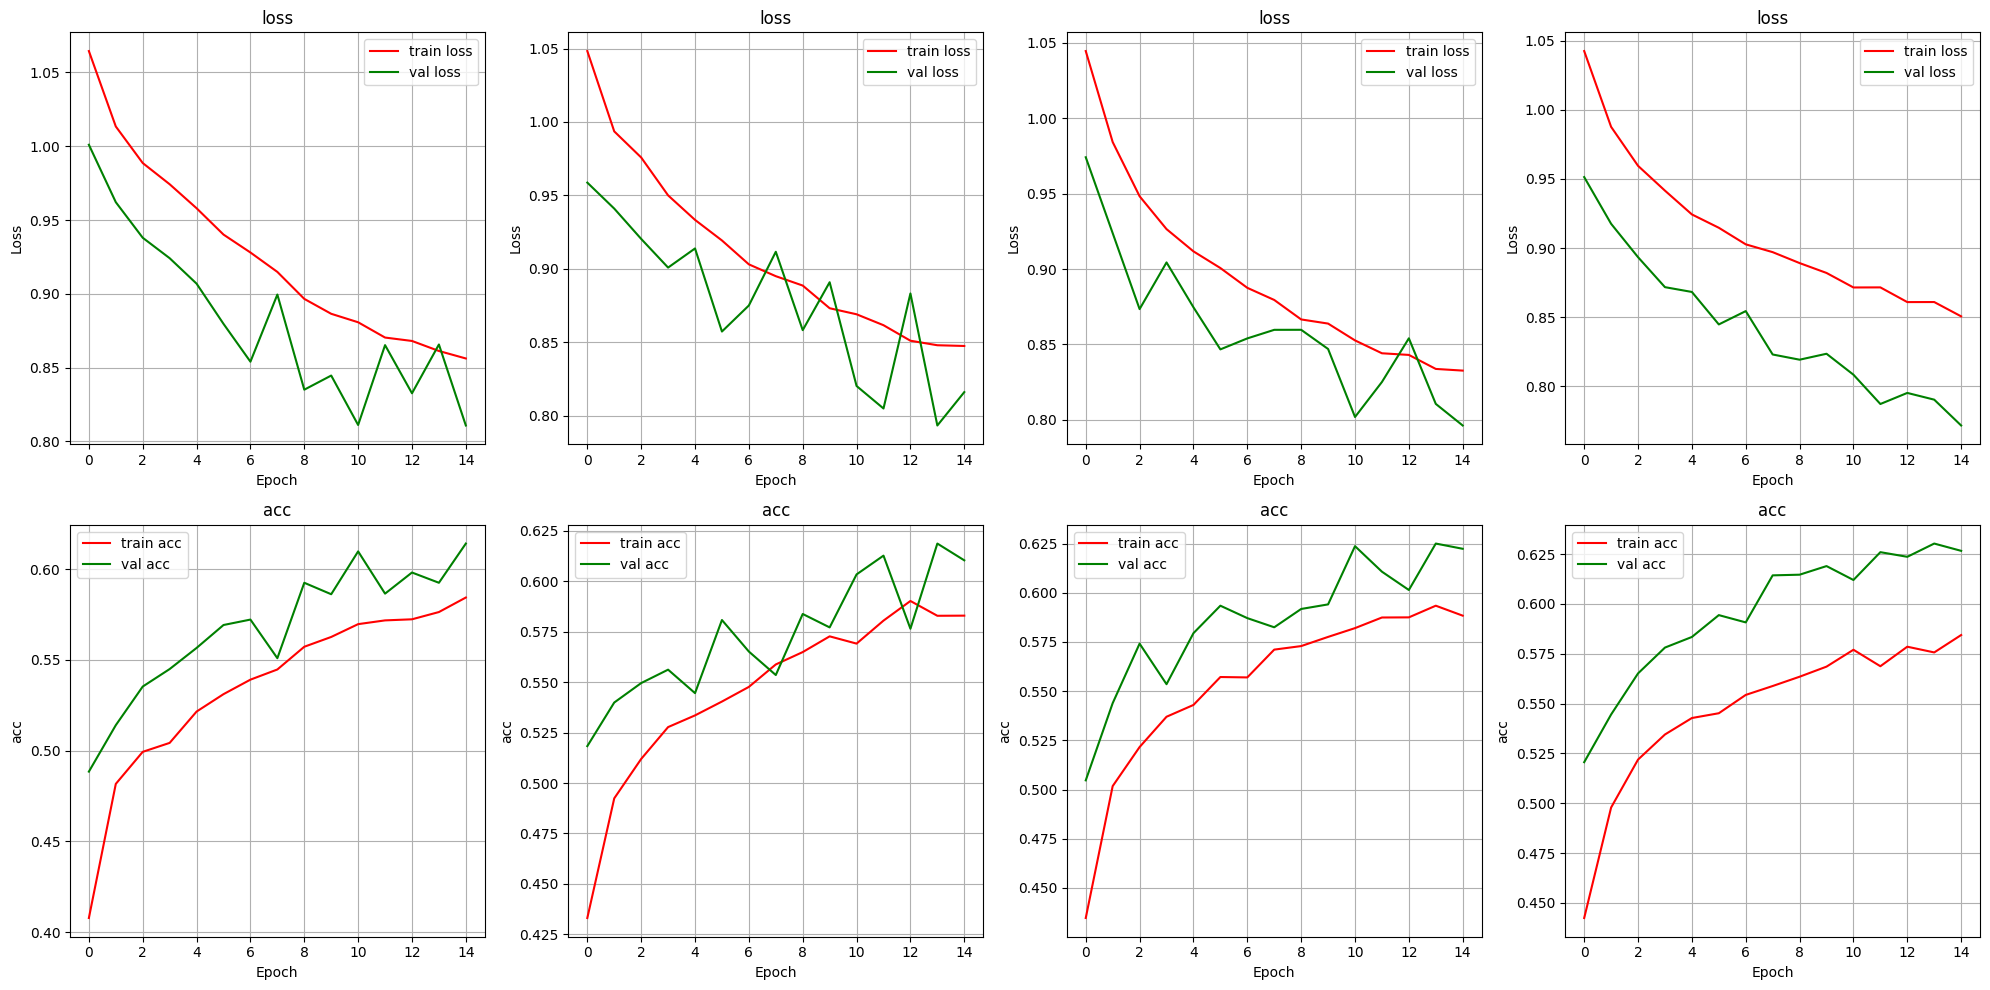

In [100]:
# Main loop
kernel_sizes = [5, 7, 9, 11]
num_epochs = 15

# Create plots
fig, axs = plt.subplots(2, len(kernel_sizes), figsize=(20, 10))

for i, kernel_size in enumerate(kernel_sizes):

    print(f"Training with kernel size: {kernel_size}")

    model = CNN(kernel_size=kernel_size)

    # Train the model
    epoch_t_loss, epoch_v_loss, epoch_t_acc, epoch_v_acc = fit(model, dataloader, epochs=num_epochs)

    # Plot training and validation loss
    axs[0, i].plot(epoch_t_loss, 'r')
    axs[0, i].plot(epoch_v_loss, 'g')
    axs[0, i].set_title('loss')
    axs[0, i].set_xlabel('Epoch')
    axs[0, i].set_ylabel('Loss')
    axs[0, i].legend(['train loss', 'val loss'])
    axs[0, i].grid()

    # Plot training and validation accuracy
    axs[1, i].plot(epoch_t_acc, 'r')
    axs[1, i].plot(epoch_v_acc, 'g')
    axs[1, i].set_title('acc')
    axs[1, i].set_xlabel('Epoch')
    axs[1, i].set_ylabel('acc')
    axs[1, i].legend(['train acc', 'val acc'])
    axs[1, i].grid()

plt.tight_layout()
plt.show()

- se obtiene un mejor comportamiento con el kernel de tamaño 11.

---

# Parte 2.b

Empleando el modelo entrenado y elegido por Ud. en el punto anterior, realice transfer learning para indentificar del mismo dataset CIFAR10 las clases `['plane', 'car']`.

Compare la evolución de la función de perdida y accuracy realizando transfer learning vs entrenando el modelo desde cero.


Compare los resultados finales y comente.

# Implementación 2.b

### Armado de Datasets y Dataloarders

In [101]:
classes = original_train_dataset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

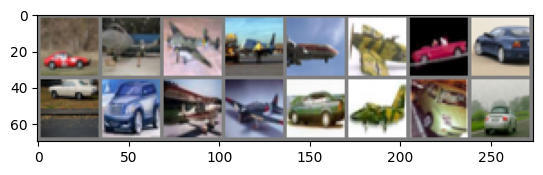

automobile airplane airplane airplane airplane airplane automobile automobile automobile automobile airplane airplane automobile airplane automobile automobile


In [102]:
# Elegir 2 nuevas clases ('car', 'plane')
classes = original_train_dataset.classes
selected_classes = ['automobile', 'airplane']
selected_class_indices = [classes.index(cls) for cls in selected_classes]

# Crear un nuevo conjunto de datos filtrado
filtered_train_dataset_B = FilteredDataset(original_train_dataset, selected_class_indices)
filtered_test_dataset_B = FilteredDataset(original_test_dataset, selected_class_indices)

# define tamaño de batch
batch_size = 16

# Crear un DataLoader para el nuevo conjunto de datos
trainloader = DataLoader(filtered_train_dataset_B, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(filtered_test_dataset_B, batch_size=batch_size, shuffle=False, num_workers=2)

# Función para mostrar imágenes
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Obtener un lote de entrenamiento
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Mostrar imágenes
imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{selected_classes[labels[j]]}' for j in range(batch_size)))


### Entrenamiento implementando Transfer Learning: Fine Tunning

Se va a cargar el modelo preentrenado y se va a resetear la ultima capa densa (fully connected).

In [103]:
model

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(11, 11), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.7, inplace=False)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(11, 11), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(11, 11), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(11, 11), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=256, out_features=3, bias=True)
)

In [104]:
model.fc

Linear(in_features=256, out_features=3, bias=True)

In [105]:
model_ft = model #hago una copia del modelo para hacerle el fine tunning

model_ft.fc = torch.nn.Linear(256, 2)  # 256 = model_ft.fc.in_features
model_ft = model_ft.to(device)

dataloader = {
    'train': trainloader,
    'test': testloader
}

In [106]:
epoch_t_loss, epoch_v_loss, epoch_t_acc, epoch_v_acc = fit(model_ft, dataloader, epochs=num_epochs)

Epoch 15/15 loss 0.30209 val_loss 0.21175 acc 0.86040 val_acc 0.91050


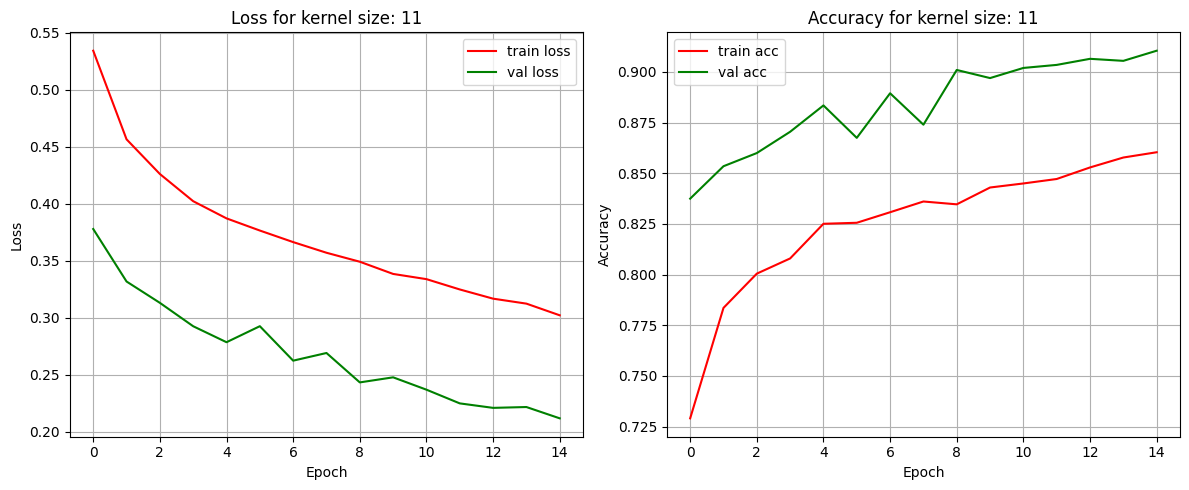

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotear la pérdida de entrenamiento y validación
axs[0].plot(epoch_t_loss, 'r', label='train loss')
axs[0].plot(epoch_v_loss, 'g', label='val loss')
axs[0].set_title(f'Loss for kernel size: {kernel_size}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Plotear la precisión de entrenamiento y validación
axs[1].plot(epoch_t_acc, 'r', label='train acc')
axs[1].plot(epoch_v_acc, 'g', label='val acc')
axs[1].set_title(f'Accuracy for kernel size: {kernel_size}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid()

# Ajustar el layout
plt.tight_layout()
plt.show()

Vemos una gran mejora en el valor de Accuracy que se logra utilizando un fine tunning. Esto porque se posee gran cantidad de datos y de caracterísitcas similares (ya que provienen del mismo dataset).

### Entrenamiento implementando Transfer Learning: Feature Extractor

En este caso se van a congelar los parámetros de todas las capas convolucionales excepto la fully connected, la cual se va a reentrenar.

In [108]:
model_fe = model #hago una copia del modelo para hacerle el feature extractor

for param in model_fe.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_fe.fc.in_features
model_fe.fc = torch.nn.Linear(num_ftrs, 2)
model_fe = model_fe.to(device)
criterion = torch.nn.CrossEntropyLoss()

dataloader = {
    'train': trainloader,
    'test': testloader
}

In [109]:
epoch_t_loss, epoch_v_loss, epoch_t_acc, epoch_v_acc = fit(model_fe, dataloader, epochs=num_epochs)

Epoch 15/15 loss 0.29906 val_loss 0.21247 acc 0.85920 val_acc 0.91000


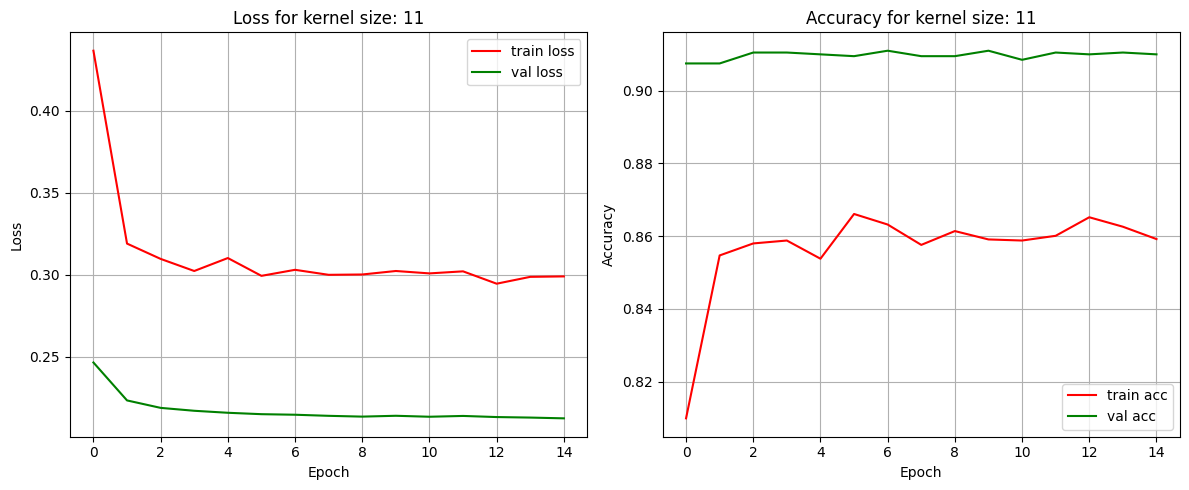

In [110]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotear la pérdida de entrenamiento y validación
axs[0].plot(epoch_t_loss, 'r', label='train loss')
axs[0].plot(epoch_v_loss, 'g', label='val loss')
axs[0].set_title(f'Loss for kernel size: {kernel_size}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Plotear la precisión de entrenamiento y validación
axs[1].plot(epoch_t_acc, 'r', label='train acc')
axs[1].plot(epoch_v_acc, 'g', label='val acc')
axs[1].set_title(f'Accuracy for kernel size: {kernel_size}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid()

# Ajustar el layout
plt.tight_layout()
plt.show()

### Entrenamiento implementando Transfer Learning: Feature Extractor de menor profundidad

La arquitectura final de la parte A tiene 4 capas convolucionales y una capa fully connected. Se van a congelar los parámetros de las primeras 3 capas convolucionales y se van a reentrenar la 4ta capa conv. y la fully connected.

In [111]:
torch.nn.ModuleList(model.children())[:-2]

ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(11, 11), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Dropout2d(p=0.7, inplace=False)
  (2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(11, 11), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(11, 11), stride=(1, 1), padding=same)
    (1): Tanh()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
)

#### Cálculo de los `in_features` (salida de la última capa convolucional del extractor)

Dado que la CNN recibe imágenes de tamaño `3 x 32 x 32` y pasa a través de varias capas convolucionales y de `MaxPool2d`, calculamos el tamaño de salida de la última capa convolucional paso a paso.

#### Paso 1: Primera capa convolucional y pooling
- **Entrada**: `3 x 32 x 32`
- **Capa convolucional 1** (`Conv2d(3, 8, kernel_size=11, stride=1, padding='same')`):
  - Tamaño de salida: `8 x 32 x 32` (como el padding es `'same'`, la salida conserva el tamaño espacial).
  
- **Pooling 1** (`MaxPool2d(kernel_size=3, stride=2, padding=1)`):
  - Nueva salida: `8 x 16 x 16` (el tamaño espacial se reduce a la mitad debido al stride de 2).

#### Paso 2: Segunda capa convolucional y pooling
- **Entrada**: `8 x 16 x 16`
- **Capa convolucional 2** (`Conv2d(8, 16, kernel_size=11, stride=1, padding='same')`):
  - Tamaño de salida: `16 x 16 x 16` (con padding `'same'`, se mantiene el tamaño espacial).

- **Pooling 2** (`MaxPool2d(kernel_size=3, stride=2, padding=1)`):
  - Nueva salida: `16 x 8 x 8` (reducción espacial por el `MaxPool2d`).

#### Paso 3: Tercera capa convolucional y pooling
- **Entrada**: `16 x 8 x 8`
- **Capa convolucional 3** (`Conv2d(16, 32, kernel_size=11, stride=1, padding='same')`):
  - Tamaño de salida: `32 x 8 x 8` (de nuevo, el padding `'same'` conserva las dimensiones espaciales).

- **Pooling 3** (`MaxPool2d(kernel_size=3, stride=2, padding=1)`):
  - Nueva salida: `32 x 4 x 4` (reducción espacial por el `MaxPool2d`).


La salida de la última capa convolucional tiene dimensiones `32 x 4 x 4`. Por lo tanto, el número de `in_features` que necesitas para la capa fully connected es: 512


In [112]:
# nueva clase para lograr un feature extractor de menor profundidad

class MyCustomCNN(torch.nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()

        self.features = torch.nn.ModuleList(model.children())[:-2]

        # implemento el paso forward de las capas propias de feature extractor
        self.fixed_features = torch.nn.Sequential(*self.features)

        in_features = 4*4*32 # [hor x ver x chan]

        # ahora si, colocamos las capas deseadas
        self.fc0 = torch.nn.Linear(in_features, 256)
        self.fc0_bn = torch.nn.BatchNorm1d(256, eps = 1e-2)
        self.fc1 = torch.nn.Linear(256, 2)
        self.fc1_bn = torch.nn.BatchNorm1d(2, eps = 1e-2)

        # initialize all fc layers to xavier
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_normal_(m.weight, gain = 1)

    def forward(self, input_imgs):
       # now in forward pass, you have the full control,
       # we can use the feature part from our pretrained model  like this
        output = self.fixed_features(input_imgs)
        # since we are using fc layers from now on, we need to flatten the output.
        # we used the avgpooling but we still need to flatten from the shape (batch, 1,1, features)
        # to (batch, features) so we reshape like this. input_imgs.size(0) gives the batchsize, and
        # we use -1 for inferring the rest
        output = output.view(input_imgs.size(0), -1)
       # and also our new layers.
        output = self.fc0_bn(torch.relu(self.fc0(output)))
        output = self.fc1_bn(torch.relu(self.fc1(output)))

        return output

In [113]:
# Chequeo que el modelo tenga bien configurado los inputs pasandole un batch de imagenes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_fe2 = MyCustomCNN().to(device)  # Mover el modelo a la GPU

input_imgs = next(dataiter)[0].to(device)  # Mover las imágenes a la GPU
output = model_fe2(input_imgs)  # Realizar el forward pass
output

tensor([[ 1.0756, -0.6566],
        [-0.6673, -0.6566],
        [-0.6673, -0.4617],
        [-0.6673, -0.6566],
        [-0.6673,  1.0110],
        [ 2.6572,  1.3418],
        [ 0.6832,  0.5832],
        [ 0.7431, -0.6566],
        [-0.6673, -0.6566],
        [-0.3352,  1.3626],
        [-0.6673, -0.6566],
        [-0.3696, -0.6566],
        [ 1.4578, -0.4535],
        [-0.6673, -0.6566],
        [-0.6171,  2.5263],
        [-0.6238, -0.6566]], device='cuda:0',
       grad_fn=<NativeBatchNormBackward0>)

In [114]:
epoch_t_loss, epoch_v_loss, epoch_t_acc, epoch_v_acc = fit(model_fe2, dataloader, epochs=num_epochs)

Epoch 15/15 loss 0.29042 val_loss 0.21788 acc 0.87190 val_acc 0.91250


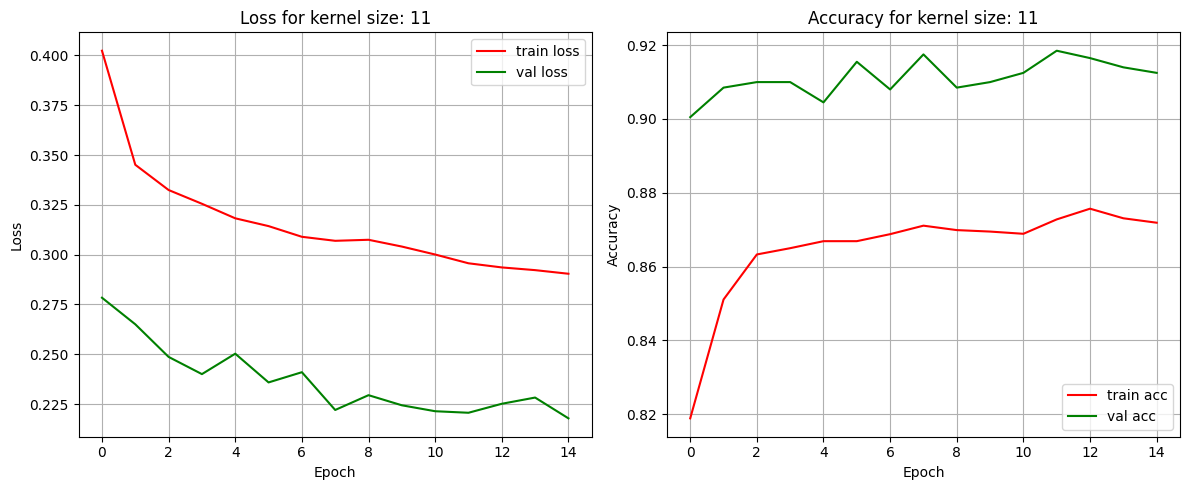

In [115]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotear la pérdida de entrenamiento y validación
axs[0].plot(epoch_t_loss, 'r', label='train loss')
axs[0].plot(epoch_v_loss, 'g', label='val loss')
axs[0].set_title(f'Loss for kernel size: {kernel_size}')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid()

# Plotear la precisión de entrenamiento y validación
axs[1].plot(epoch_t_acc, 'r', label='train acc')
axs[1].plot(epoch_v_acc, 'g', label='val acc')
axs[1].set_title(f'Accuracy for kernel size: {kernel_size}')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid()

# Ajustar el layout
plt.tight_layout()
plt.show()

## Conclusión

- En los tres casos de aplicación de transfer learning se obtuvieron muy buenos resultados, mejores que en el entrenamiento del modelo desde cero.

- El mejor resultado de la métrica de Accuracy fue para el feature extractor de menor profundidad (utilizando algunas capas convolucionales). Esto se debe a que las características de las imágenes a clasificar eran similares respecto de las características aprendidas en la parte A. Y a su vez se le da el margen a la red de aprender caraterísticas propias de las nuevas clases a utilizar, en conjunto de dos capas densas.